# Introduction

In this project, I will analyze Amazon sales data to understand the distribution of products by categories, customer ratings, and reviews and use the insights gained to help inform company decision making, improve product offering and enhance customer experience.

## Key Tasks and Questions
* Identify all unique catogries of products
* Identify the highest rated product for each unique category
* Identify the average discount product cost per category,and the lowest and highest product cost per category
* Identify high performing categories and their average ratings for each
* Identify the highest rated catorgies and the average ratings for high performing categories
* Analyze the correlation between product rating and discounts across different categories
* Identify common themes per category via customer reviews and review titles


# Data Source

The dataset used is the Amazon Sales Dataset from Kaggle. It contains the data for over 1,000 ratings and reviews from the Amazon website and has 16 columns covering product information, sales category, pricing, reviews, and ratings.

### Editing CSV in Sheets

I removed uneccessary columns from the csv in sheets. The orignal csv contains the columns:
* product_id - Product ID
* product_name - Name of the Product
* category - Category of the Product
* discounted_price - Discounted Price of the Product
* actual_price - Actual Price of the Product
* discount_percentage - Percentage of Discount for the Product
* rating - Rating of the Product
* rating_count - Number of people who voted for the Amazon rating
* about_product - Description about the Product
* user_id - ID of the user who wrote review for the Product
* user_name - Name of the user who wrote review for the Product
* review_id - ID of the user review
* review_title - Short review
* review_content - Long review
* img_link - Image Link of the Product
* product_link - Official Website Link of the Product

The columns I will be using in PostgresQL are:
* product_id - Product ID
* product_name - Name of the Product
* category - Category of the Product
* discounted_price - Discounted Price of the Product
* actual_price - Actual Price of the Product
* discount_percentage - Percentage of Discount for the Product
* rating - Rating of the Product
* rating_count - Number of people who voted for the Amazon rating
* about_product - Description about the Product
* review_id - ID of the user review
* review_title - Short review

### Initial Data Observations
* There are 1465 products in the dataset
* The currency is currently in INR instead of USD
* All of the columns are in the text data type.


# Data Preperation

I will inspect the data set for null values, duolicates, inconsitent data, clean the data by correcting any errors, and transform data for analysis. I will then save the query as my working query.

### Check for null values

In [3]:
SELECT DISTINCT COUNT(product_id)
FROM public.amazon_sales2
WHERE product_id IS NULL;

SyntaxError: invalid syntax (1675147653.py, line 1)

In [ ]:
SELECT DISTINCT COUNT(SUBSTRING(category FROM 0 FOR POSITION('|' in category))) AS unique_category
FROM public.amazon_sales2
WHERE category IS NULL;

Both returned 0 for checking nulls in product_id and category. 

In [ ]:
SELECT DISTINCT COUNT(SUBSTRING(category FROM 0 FOR POSITION('|' in category))) AS unique_category
FROM public.amazon_sales2;

In [ ]:
SELECT DISTINCT COUNT(product_id)
FROM public.amazon_sales2

Both have a count of 1465 which is consistent with the number of products in the dataset. There are no null or duplicate values in the dataset.

### Data Cleaning and Transformation
Issues to address:
* format the category column so that it is more readable, 
* remove currency, percentage, and other non numeric symbols from discounted_price, actual_price, discounted_perc, rating, and rating_count
* convert discounted_price, actual_price, discounted_perc, rating, and rating_count to numeric data type
* convert discounted_price and actual_price from INR to USD currency
* recheck for null values and any other problems

In [ ]:
WITH 
	nonsym ## transforming columns to ideal form for analysis and preparing for data type conversion
	AS
		(SELECT 
		 	product_id,
		 	product_name,
			SUBSTRING(category FROM 0 FOR POSITION('|' in category)) AS category,
			REPLACE(SUBSTRING(discounted_price, 2, LENGTH(discounted_price)),',','') AS discount_price, 
			REPLACE(SUBSTRING(actual_price, 2, LENGTH(actual_price)),',','') AS actual_price,
			SUBSTRING(discount_percentage FROM 0 FOR POSITION('%' in discount_percentage)) AS discount_perc,
			REPLACE(rating,'|','0') AS rating,
			REPLACE(rating_count,',','') AS rating_count,
			review_title
		FROM public.amazon_sales2),
	dataconv
	AS
		(SELECT
		 	product_id,
		 	product_name,
		 	category,
			CAST(discount_price AS numeric),
		 	CAST(actual_price AS numeric),
		 	CAST(discount_perc AS numeric),
		 	CAST(rating AS numeric),
		 	CAST(rating_count AS numeric),
		 	review_title
		FROM nonsym)
SELECT 
	product_id,
	product_name,
	category,
	ROUND((discount_price * 0.0120),2) AS discount_price_USD, ## currency conversion from INR to USD
	ROUND((actual_price * 0.0120),2) AS actual_price_USD, ## currency conversion from INR to USD
	discount_perc,
	rating,
	COALESCE(rating_count,0) AS rating_count, ## remove null value that came as result of data type conversion
	review_title
FROM dataconv;

I will then save this new cleaned data table to work from as a new csv file title clean_amazon_sales.csv

# Exploratory Analysis

#### Identify all unique catogries of products

In [ ]:
SELECT category, COUNT(category)
FROM public.clean_amazon_sales
GROUP BY category
ORDER BY COUNT DESC;

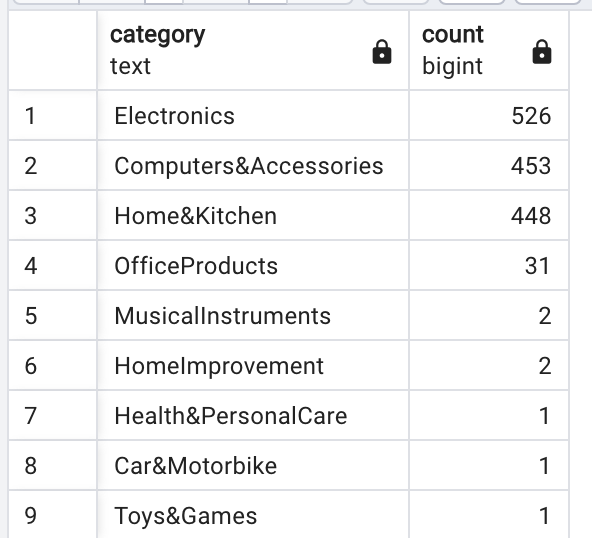

There are 9 main categories with Electronics, Computers and Accessories, and Home and Kitchen bieng the categories with the most product sales.

#### Identify the highest rated product for each unique category

In [ ]:
SELECT category, LEFT(product_name,65), rating 
FROM 
(SELECT category, product_name, rating, DENSE_RANK() OVER(PARTITION BY category ORDER BY rating DESC) AS cat_max_rating
FROM public.clean_amazon_sales
GROUP BY rating, category, product_name)
WHERE cat_max_rating = 1
ORDER BY category, rating DESC;

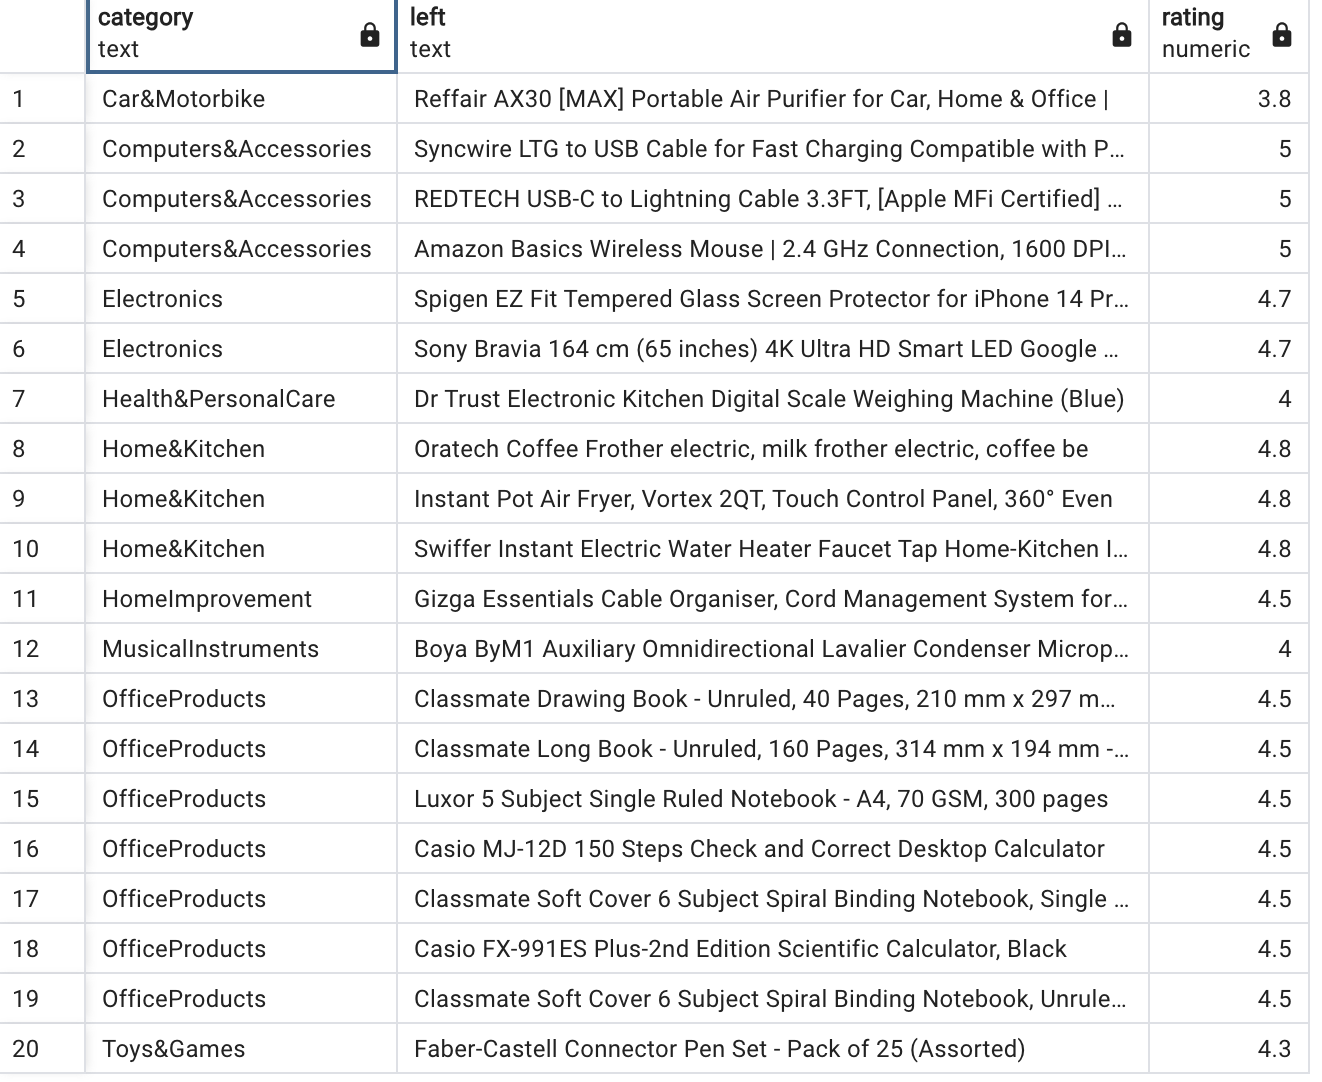

Computer and Acessories have three products with the highest rating of 5. All of the products are computer accessories two of which are USB cables and the third is a computer mouse. The next highest rated products at a 4.8 rating comes from the Home and Kitchen category and they are a coffee frother, air fryer, and an electric water heater. The Car and Motorbike category highest rated product is a portable air purifeir for the car and it is only at a 3.8 rating. There is only one product sale for this category and its only sale is an average rating.

#### Identify the average discount product cost per category,and the lowest and highest product cost per category

In [ ]:
SELECT category, 
	ROUND(AVG(AVG("discount_price_USD"))OVER(PARTITION BY category),2) AS average_discount_cost,
	MAX(MAX("discount_price_USD"))OVER(PARTITION BY category) AS max_discount_cost,
	MIN(MIN("discount_price_USD"))OVER(PARTITION BY category) AS min_discount_cost
FROM public.clean_amazon_sales
GROUP BY category
ORDER BY average_discount_cost DESC, max_discount_cost DESC;

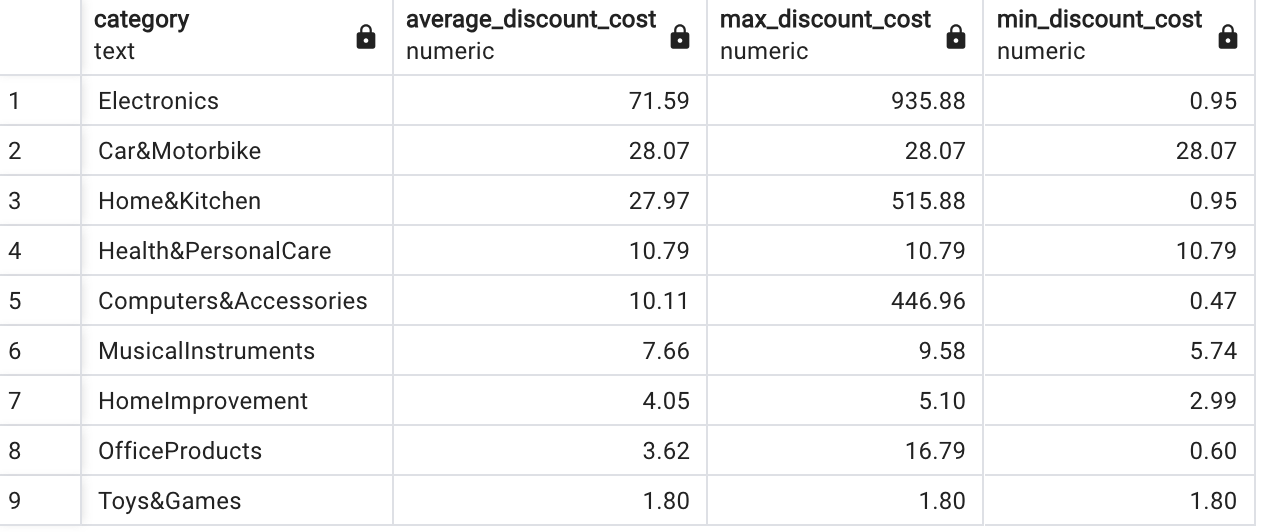

Looking at the top three selling categories, in terms of product sales, Computer and Accessories has the lowest average discount cost at 10.11. Electronics has the highest average discount cost at 71.59. Computers and Accessories also has the lowest minimum discounted price as well at only 0.47.

#### Identify high performing categories and their average ratings for each

Based on previous tables in the analysis, Electronics, Computers and Accessories, and Home and Kitchen are the highest performing categories. 

In [ ]:
SELECT category,
	ROUND(AVG(AVG(rating))OVER(PARTITION BY category),2) AS avg_rating
FROM public.clean_amazon_sales
GROUP BY category
HAVING category IN ('Electronics','Home&Kitchen','Computers&Accessories')
ORDER BY avg_rating DESC;

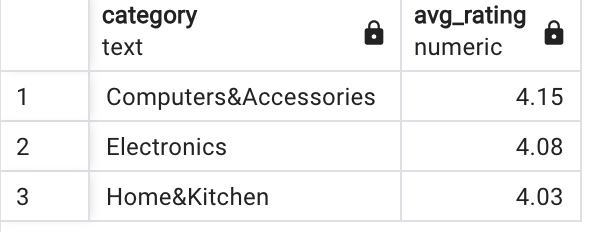

The average rating for the high performing categories are over 4 and closer to that mark. This tells us that not only are these categories high in product sales but most customers are satisfied with there purchase in these categories.

#### Analyze the correlation between average product rating and average discount cost across highest rated categories

In [ ]:
SELECT category, ROUND(AVG(rating),2) AS avg_rating, ROUND(AVG("discount_price_USD"),2) AS avg_discount_price, corr(rating,"discount_price_USD")
FROM public.clean_amazon_sales
GROUP BY category
HAVING category IN ('Computers&Accessories','Electronics','Home&Kitchen')

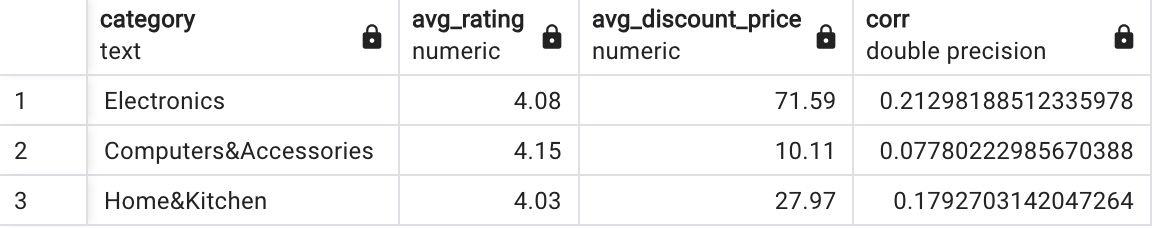

There is little to no correlation between product rating and its discount cost across the highest rated categories.

#### Identify common themes in reviews for high performance category via customer review titles

* Computers and Accessories

In [ ]:
SELECT category, LEFT(product_name,65), cat_rating, rating, LEFT(review_title,50)
FROM 
	(SELECT category, product_name, rating, review_title, 
 	DENSE_RANK() OVER(PARTITION BY category ORDER BY rating DESC) AS cat_rating
	FROM public.clean_amazon_sales
	GROUP BY rating, category, product_name, review_title
	HAVING category IN ('Computers&Accessories'))
GROUP BY category,product_name, cat_rating, rating,review_title
HAVING cat_rating = 1 OR cat_rating >= 16
ORDER BY category, cat_rating DESC

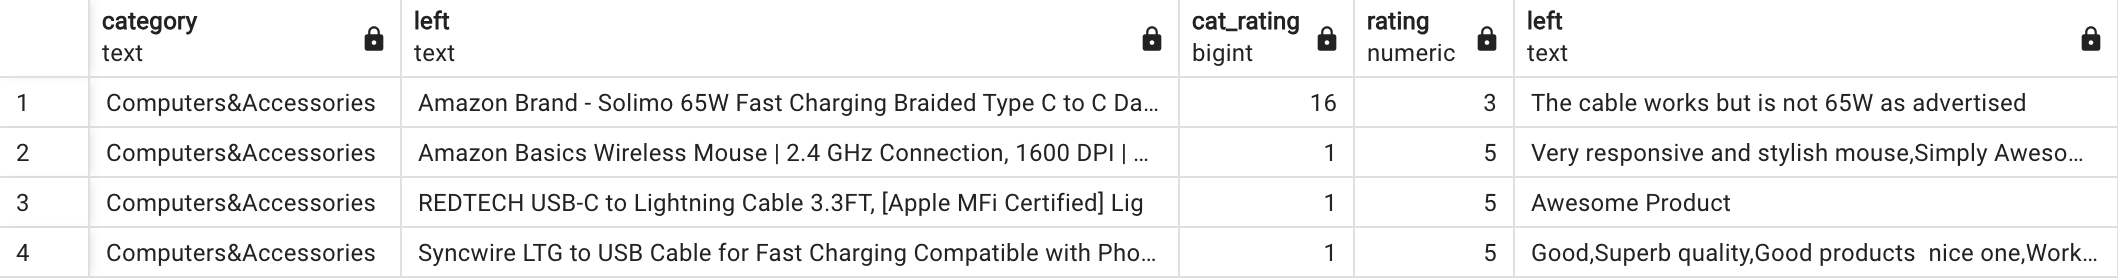

The lowest rating for a product in Computer and Accessories is a 3 rating which is an average rating. The review says that though the product works, what the consumer received is not what was advertised in the originial product listing.

* Electronics

In [ ]:
SELECT category, LEFT(product_name,65), cat_rating, rating, LEFT(review_title,50)
FROM 
	(SELECT category, product_name, rating, review_title, 
 	DENSE_RANK() OVER(PARTITION BY category ORDER BY rating DESC) AS cat_rating
	FROM public.clean_amazon_sales
	GROUP BY rating, category, product_name, review_title
	HAVING category IN ('Electronics'))
GROUP BY category,product_name, cat_rating, rating,review_title
HAVING cat_rating = 1 OR cat_rating >= 16
ORDER BY category, cat_rating DESC

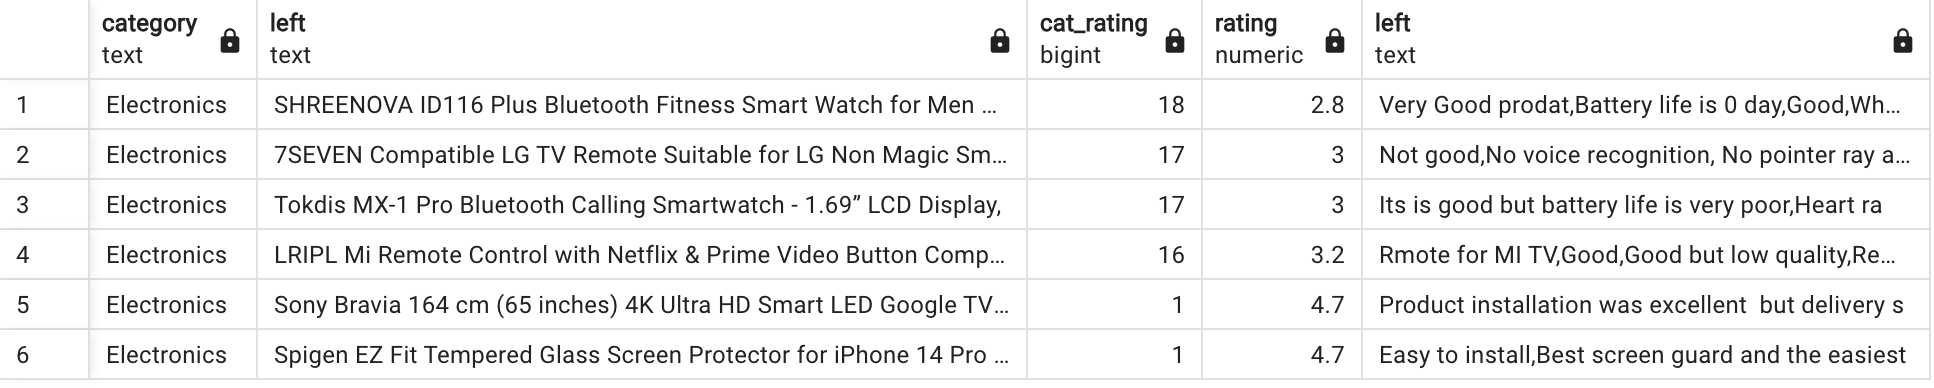

The lowest rating in the Electronics category is a 2.8 rating. The product is a smart wartch but the battery life is really bad for the product. The other low rated products also report a low battery life, low performance, and an overall low quality product that does not work as advertised. The highest rated products both report easy installation and high quality. 

* Home and Kitchen

In [ ]:
SELECT category, LEFT(product_name,65), cat_rating, rating, LEFT(review_title,65)
FROM 
	(SELECT category, product_name, rating, review_title, 
 	DENSE_RANK() OVER(PARTITION BY category ORDER BY rating DESC) AS cat_rating
	FROM public.clean_amazon_sales
	GROUP BY rating, category, product_name, review_title
	HAVING category IN ('Home&Kitchen'))
GROUP BY category,product_name, cat_rating, rating,review_title
HAVING cat_rating = 1 OR cat_rating >= 16
ORDER BY category, cat_rating DESC

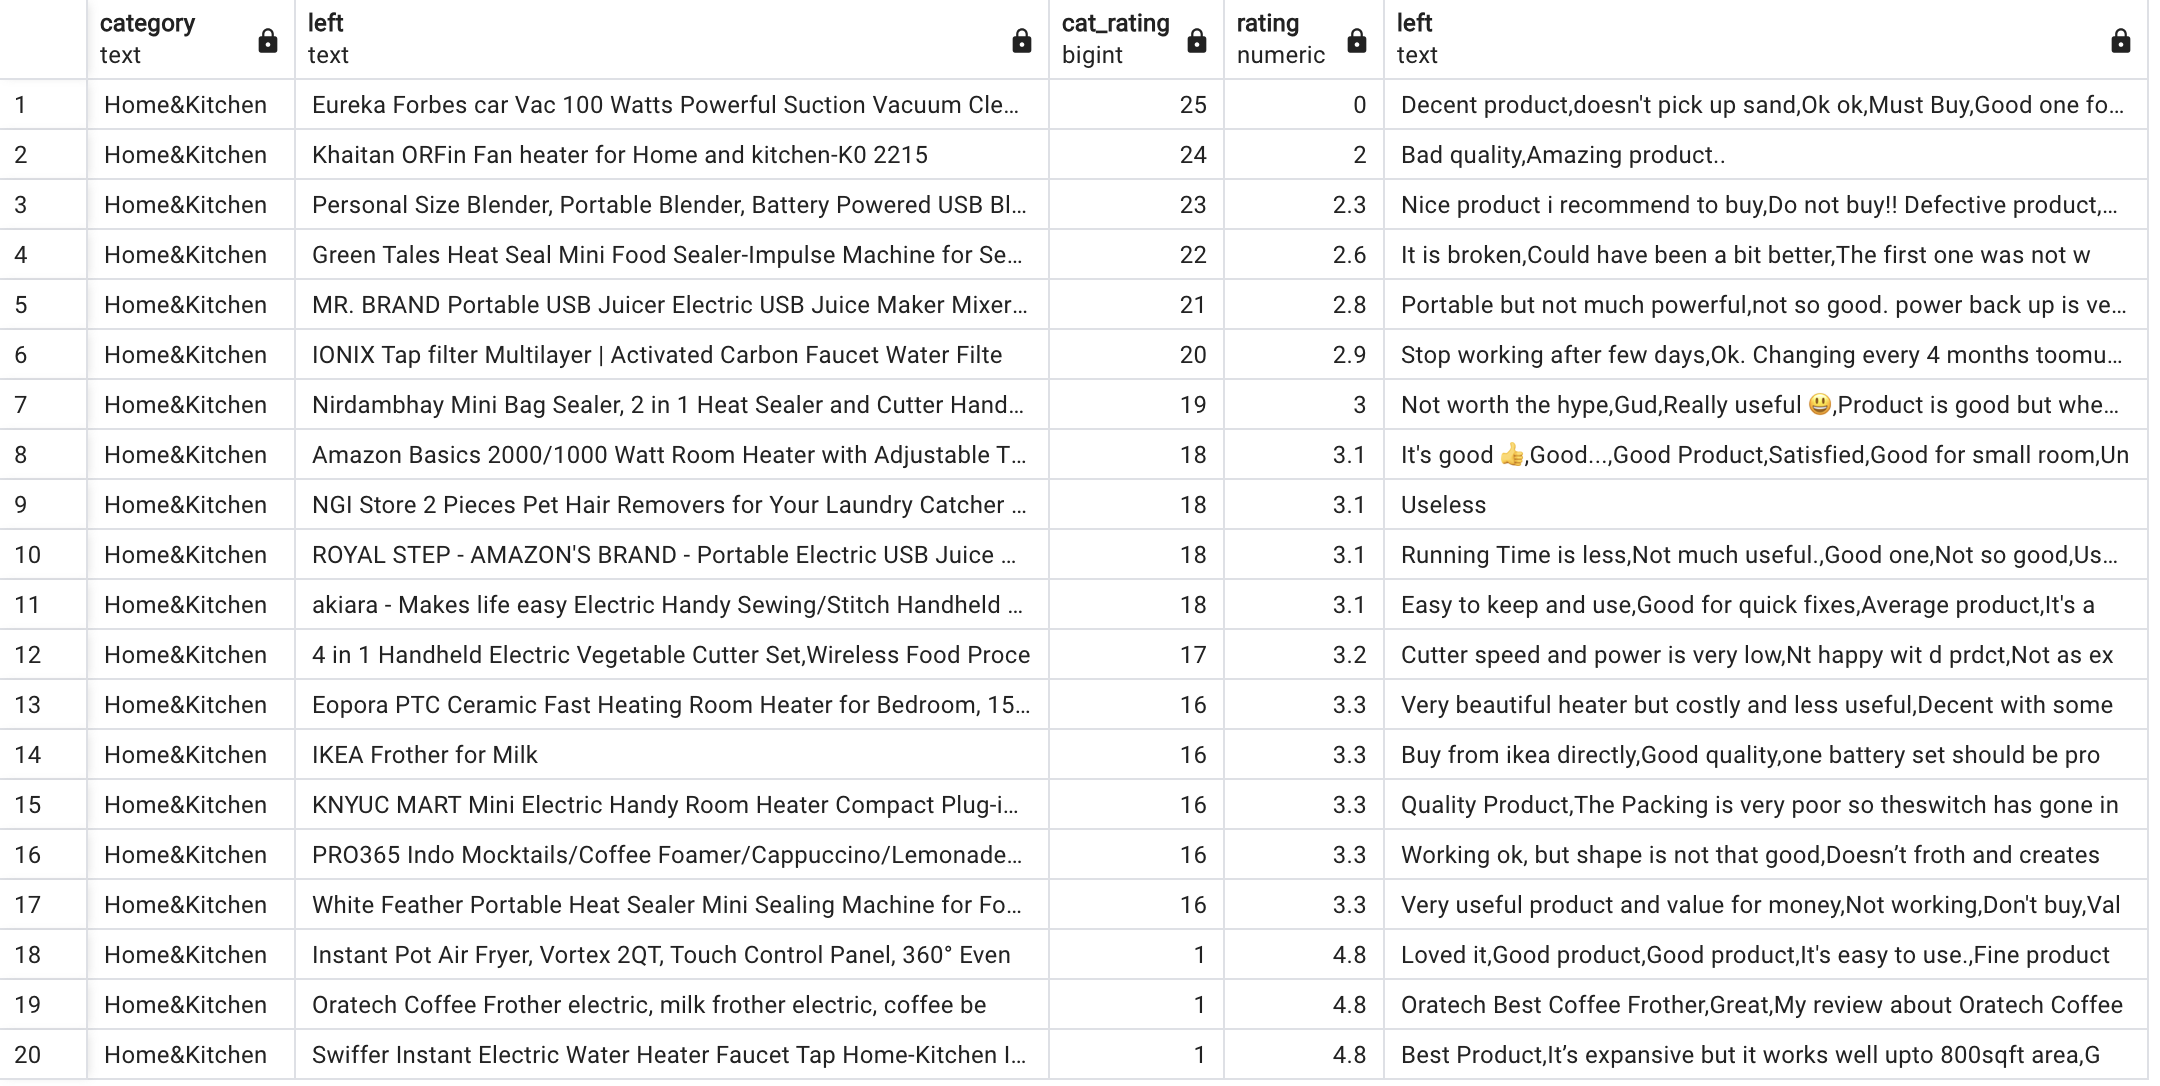

The products in the low ratings have ratings between 0 and 3. The common theme in these reviews are that the product does not work, breaks down after a few uses, or is low quality. The products with high ratings have reviews stating that the product works and is also easy to use

# Key Findings

1. There are 9 categories of products in teh dataset with Electronics, Computers and Accessories, and Home and Kitchen bieng the categories with the most product sales. Health and Personal Care, Car and Motorbike, and Toys and Games are the lowest performing categories with only 1 prodcut sale in the dataset.
2. Computers and Accessories, Home and Kitchen, Electronics, and Office rRoducts have the most products with high ratings from 4.5 to 5. The average rating for Computer and Accessories, Electronics, and Home and Kitchen are in the low 4's. Most customers are staisfied with purchases in these categories. The low performing categories also acheived average ratings between 3 and 4.3, showing that for what was sold, customers had a good degree of satisfaction.
3. Computers and Accessories has the lowest average discounted price at 10.11 and it also has the lowest discounted price overall at 47 cents. However, there is little to no correlation between product rating and its discount cost across the highest rated categories.
4. In the high perfomring categories, all low rated products sold were of low performance and low quality according to the reviews. They did not live up to the product advertisment in the listing. High rated products were easy to use and of good quality according to the reviews.

# Business Recommendations
* Marketing efforts should be focused in the Computers and Accessories, Electronics, and Home and Kitchen categories as they are high performing and have the most sales traffic.
* Product quality in these categories should match the product listing and advertisements, highlighting performance quality to continuously increase high product ratings. Continued categoric centric study of review content and titles can lead to more effecient product development and overall customer satisfication.
* Product availability and marketing efforts in Musical Instruments, Home Improvement, Health and Personal Care, Car and Motorbike, and Toys and Games should be increased to improve product sales since these are lower performing categories in regards to sales. These categories might also benefit from upsell strategies by pairing products in these sectors with related items in higher performing sectors.